# Diagnosing Underfitting vs Overfitting from Training Loss Curves

## Objective
Learn to diagnose model behavior when **validation data is unavailable** by:
1. Interpreting training loss curve patterns
2. Understanding what training loss alone can (and cannot) tell you
3. Identifying additional signals that provide crucial diagnostic information

## The Challenge
Given only a training loss curve, we face ambiguity:
- **Flat training loss** → Underfitting? Or already optimal?
- **Decreasing training loss** → Learning well? Or memorizing?
- **Low training loss** → Good fit? Or overfitting?

## Key Questions
1. What patterns in training loss suggest underfitting?
2. What patterns suggest overfitting?
3. What's ambiguous from training loss alone?
4. What additional signals resolve ambiguities?

## Approach
1. Create synthetic datasets with known properties
2. Train models of varying complexity
3. Analyze training curves only
4. Identify additional diagnostic signals
5. Show how they resolve ambiguities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.interpolate import make_interp_spline
import warnings
warnings.filterwarnings('ignore')

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

✓ Libraries imported successfully
PyTorch version: 2.9.1


## Part 1: Synthetic Dataset with Known Complexity

We'll create a regression dataset with:
- **Known true function**: A moderately complex polynomial with some noise
- **Controlled difficulty**: Adjustable signal-to-noise ratio
- **Clear ground truth**: So we know when models are under/overfitting

This lets us train models of different complexities and observe their training curves.

### Dataset Properties:
- **Input**: 1D features (easy to visualize)
- **Output**: Continuous regression target
- **True function**: 4th degree polynomial + sin component
- **Noise level**: Moderate (allows both under and overfitting)

Training samples: 140
Validation samples: 60
Signal-to-noise ratio: 24.59


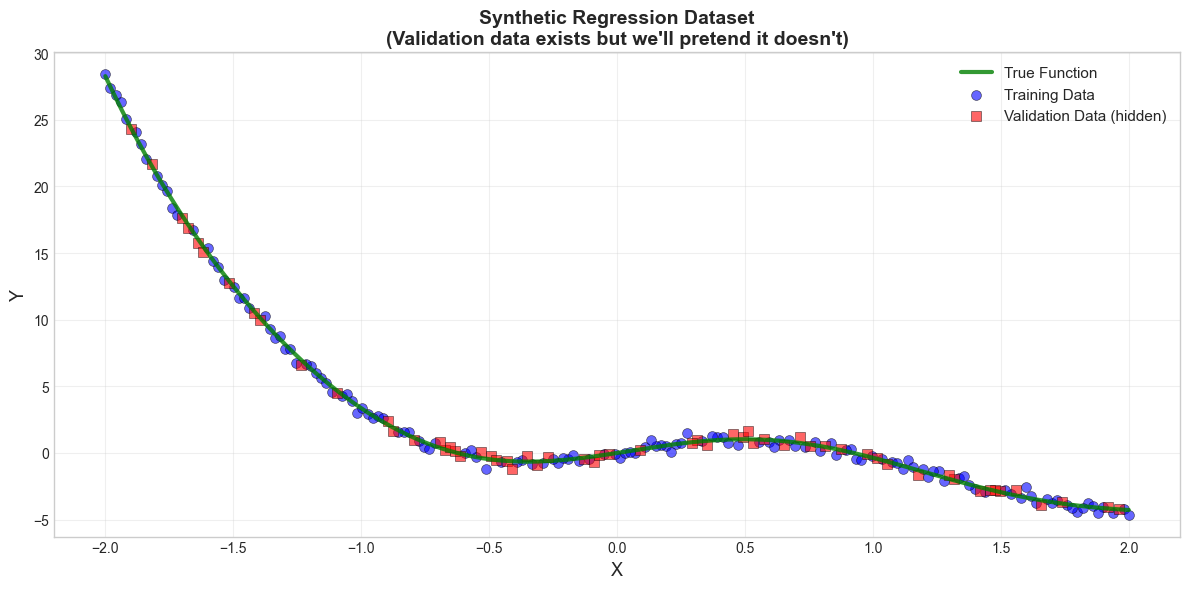

In [2]:
def generate_regression_data(n_samples=200, noise_level=0.3, random_state=42):
    """
    Generate synthetic regression data.
    True function: y = 0.5*x^4 - 2*x^3 + x^2 + sin(3*x) + noise
    """
    np.random.seed(random_state)
    
    # Generate input features
    X = np.linspace(-2, 2, n_samples)
    
    # True underlying function (complex but learnable)
    y_true = 0.5 * X**4 - 2 * X**3 + X**2 + np.sin(3 * X)
    
    # Add noise
    noise = np.random.normal(0, noise_level, n_samples)
    y = y_true + noise
    
    # Dense grid for visualization
    X_grid = np.linspace(-2, 2, 500)
    y_grid_true = 0.5 * X_grid**4 - 2 * X_grid**3 + X_grid**2 + np.sin(3 * X_grid)
    
    return X, y, y_true, X_grid, y_grid_true

# Generate data
X, y, y_true, X_grid, y_grid_true = generate_regression_data(n_samples=200, noise_level=0.3)

# Split into train and validation (but we'll pretend val doesn't exist for main analysis)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)
y_true_train = 0.5 * X_train**4 - 2 * X_train**3 + X_train**2 + np.sin(3 * X_train)
y_true_val = 0.5 * X_val**4 - 2 * X_val**3 + X_val**2 + np.sin(3 * X_val)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Signal-to-noise ratio: {np.std(y_true) / 0.3:.2f}")

# Visualize the data
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(X_grid, y_grid_true, 'g-', linewidth=3, label='True Function', alpha=0.8)
ax.scatter(X_train, y_train, c='blue', s=50, alpha=0.6, 
           edgecolors='black', linewidth=0.5, label='Training Data')
ax.scatter(X_val, y_val, c='red', s=50, alpha=0.6, marker='s',
           edgecolors='black', linewidth=0.5, label='Validation Data (hidden)')

ax.set_xlabel('X', fontsize=13)
ax.set_ylabel('Y', fontsize=13)
ax.set_title('Synthetic Regression Dataset\n(Validation data exists but we\'ll pretend it doesn\'t)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: Train Models with Different Capacities

We'll train neural networks with varying complexity:

1. **Too Simple** (Underfitting): 1 hidden layer, 5 neurons
2. **Just Right** (Good fit): 2 hidden layers, 20 neurons each
3. **Too Complex** (Overfitting): 5 hidden layers, 100 neurons each

For each model, we'll record:
- Training loss at each epoch
- Predictions on training data
- (Secretly) validation loss for verification

Then we'll analyze what can be inferred from training curves alone.

In [3]:
class FlexibleNN(nn.Module):
    """Flexible neural network with configurable architecture"""
    
    def __init__(self, input_dim=1, hidden_dims=[20, 20], output_dim=1, dropout=0.0):
        super(FlexibleNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test the architectures
models_config = {
    'Underfitting (Too Simple)': [5],
    'Good Fit (Just Right)': [20, 20],
    'Overfitting (Too Complex)': [100, 100, 100, 100, 100]
}

print("Model Architectures:")
print("="*60)
for name, hidden_dims in models_config.items():
    model = FlexibleNN(hidden_dims=hidden_dims)
    n_params = count_parameters(model)
    print(f"{name}:")
    print(f"  Hidden layers: {hidden_dims}")
    print(f"  Parameters: {n_params:,}")
    print()

Model Architectures:
Underfitting (Too Simple):
  Hidden layers: [5]
  Parameters: 16

Good Fit (Just Right):
  Hidden layers: [20, 20]
  Parameters: 481

Overfitting (Too Complex):
  Hidden layers: [100, 100, 100, 100, 100]
  Parameters: 40,701



In [4]:
def train_model_detailed(model, X_train, y_train, X_val, y_val, 
                        epochs=500, lr=0.01, batch_size=32, verbose=True):
    """
    Train model and log detailed metrics for analysis.
    """
    # Prepare data
    X_train_tensor = torch.FloatTensor(X_train.reshape(-1, 1))
    y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
    X_val_tensor = torch.FloatTensor(X_val.reshape(-1, 1))
    y_val_tensor = torch.FloatTensor(y_val.reshape(-1, 1))
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Tracking metrics
    history = {
        'train_loss': [],
        'val_loss': [],  # Secret - we won't use this for diagnosis
        'train_predictions': [],
        'gradient_norms': [],
        'weight_norms': [],
        'loss_decrease_rate': []
    }
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Compute gradient norm
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            
            optimizer.step()
            epoch_train_loss += loss.item()
        
        epoch_train_loss /= len(train_loader)
        
        # Evaluation on full training set
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_tensor)
            train_loss_full = criterion(train_pred, y_train_tensor).item()
            
            # Secret validation loss (for verification only)
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor).item()
        
        # Compute weight norm
        weight_norm = sum(p.norm().item() for p in model.parameters())
        
        # Store metrics
        history['train_loss'].append(train_loss_full)
        history['val_loss'].append(val_loss)
        history['gradient_norms'].append(total_norm)
        history['weight_norms'].append(weight_norm)
        
        # Compute loss decrease rate
        if epoch > 0:
            decrease_rate = history['train_loss'][-2] - history['train_loss'][-1]
            history['loss_decrease_rate'].append(decrease_rate)
        
        if verbose and (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss_full:.4f}, Val Loss={val_loss:.4f}")
    
    # Final predictions
    model.eval()
    with torch.no_grad():
        history['final_train_predictions'] = model(X_train_tensor).numpy()
        history['final_val_predictions'] = model(X_val_tensor).numpy()
    
    return model, history

# Train all models
print("Training models with different capacities...")
print("="*70)

trained_models = {}

for model_name, hidden_dims in models_config.items():
    print(f"\n{model_name}:")
    print("-" * 70)
    
    model = FlexibleNN(hidden_dims=hidden_dims)
    model, history = train_model_detailed(
        model, X_train, y_train, X_val, y_val,
        epochs=500, lr=0.001, batch_size=16, verbose=True
    )
    
    trained_models[model_name] = {
        'model': model,
        'history': history,
        'config': hidden_dims
    }

print("\n✓ All models trained")

Training models with different capacities...

Underfitting (Too Simple):
----------------------------------------------------------------------
Epoch 100/500: Train Loss=27.4529, Val Loss=18.0176
Epoch 200/500: Train Loss=17.3842, Val Loss=14.7234
Epoch 300/500: Train Loss=15.3973, Val Loss=13.1582
Epoch 400/500: Train Loss=13.1512, Val Loss=10.8528
Epoch 500/500: Train Loss=10.9051, Val Loss=8.4998

Good Fit (Just Right):
----------------------------------------------------------------------
Epoch 100/500: Train Loss=1.9298, Val Loss=0.8187
Epoch 200/500: Train Loss=0.3411, Val Loss=0.2606
Epoch 300/500: Train Loss=0.1737, Val Loss=0.1491
Epoch 400/500: Train Loss=0.1284, Val Loss=0.1240
Epoch 500/500: Train Loss=0.1112, Val Loss=0.1040

Overfitting (Too Complex):
----------------------------------------------------------------------
Epoch 100/500: Train Loss=0.0848, Val Loss=0.0763
Epoch 200/500: Train Loss=0.0967, Val Loss=0.1310
Epoch 300/500: Train Loss=0.0764, Val Loss=0.1058
Epo

## Part 3: What Training Loss Curves Tell Us (and Don't Tell Us)

Let's analyze the training curves WITHOUT looking at validation data.

### Patterns to Look For:

1. **Convergence Speed**
   - Fast convergence → Might be too simple OR well-initialized
   - Slow convergence → Might be too complex OR poor optimization

2. **Final Loss Value**
   - High plateau → Likely underfitting (can't fit training data)
   - Very low loss → Good fit OR overfitting (ambiguous!)
   - Zero loss → Definitely overfitting (memorization)

3. **Loss Trajectory Shape**
   - Smooth decrease → Normal learning
   - Erratic/noisy → Unstable optimization or high capacity
   - Quick drop then plateau → Hit model capacity

4. **Late-Stage Behavior**
   - Still decreasing → Not converged (keep training OR overfitting)
   - Flat plateau → Converged (to what quality?)

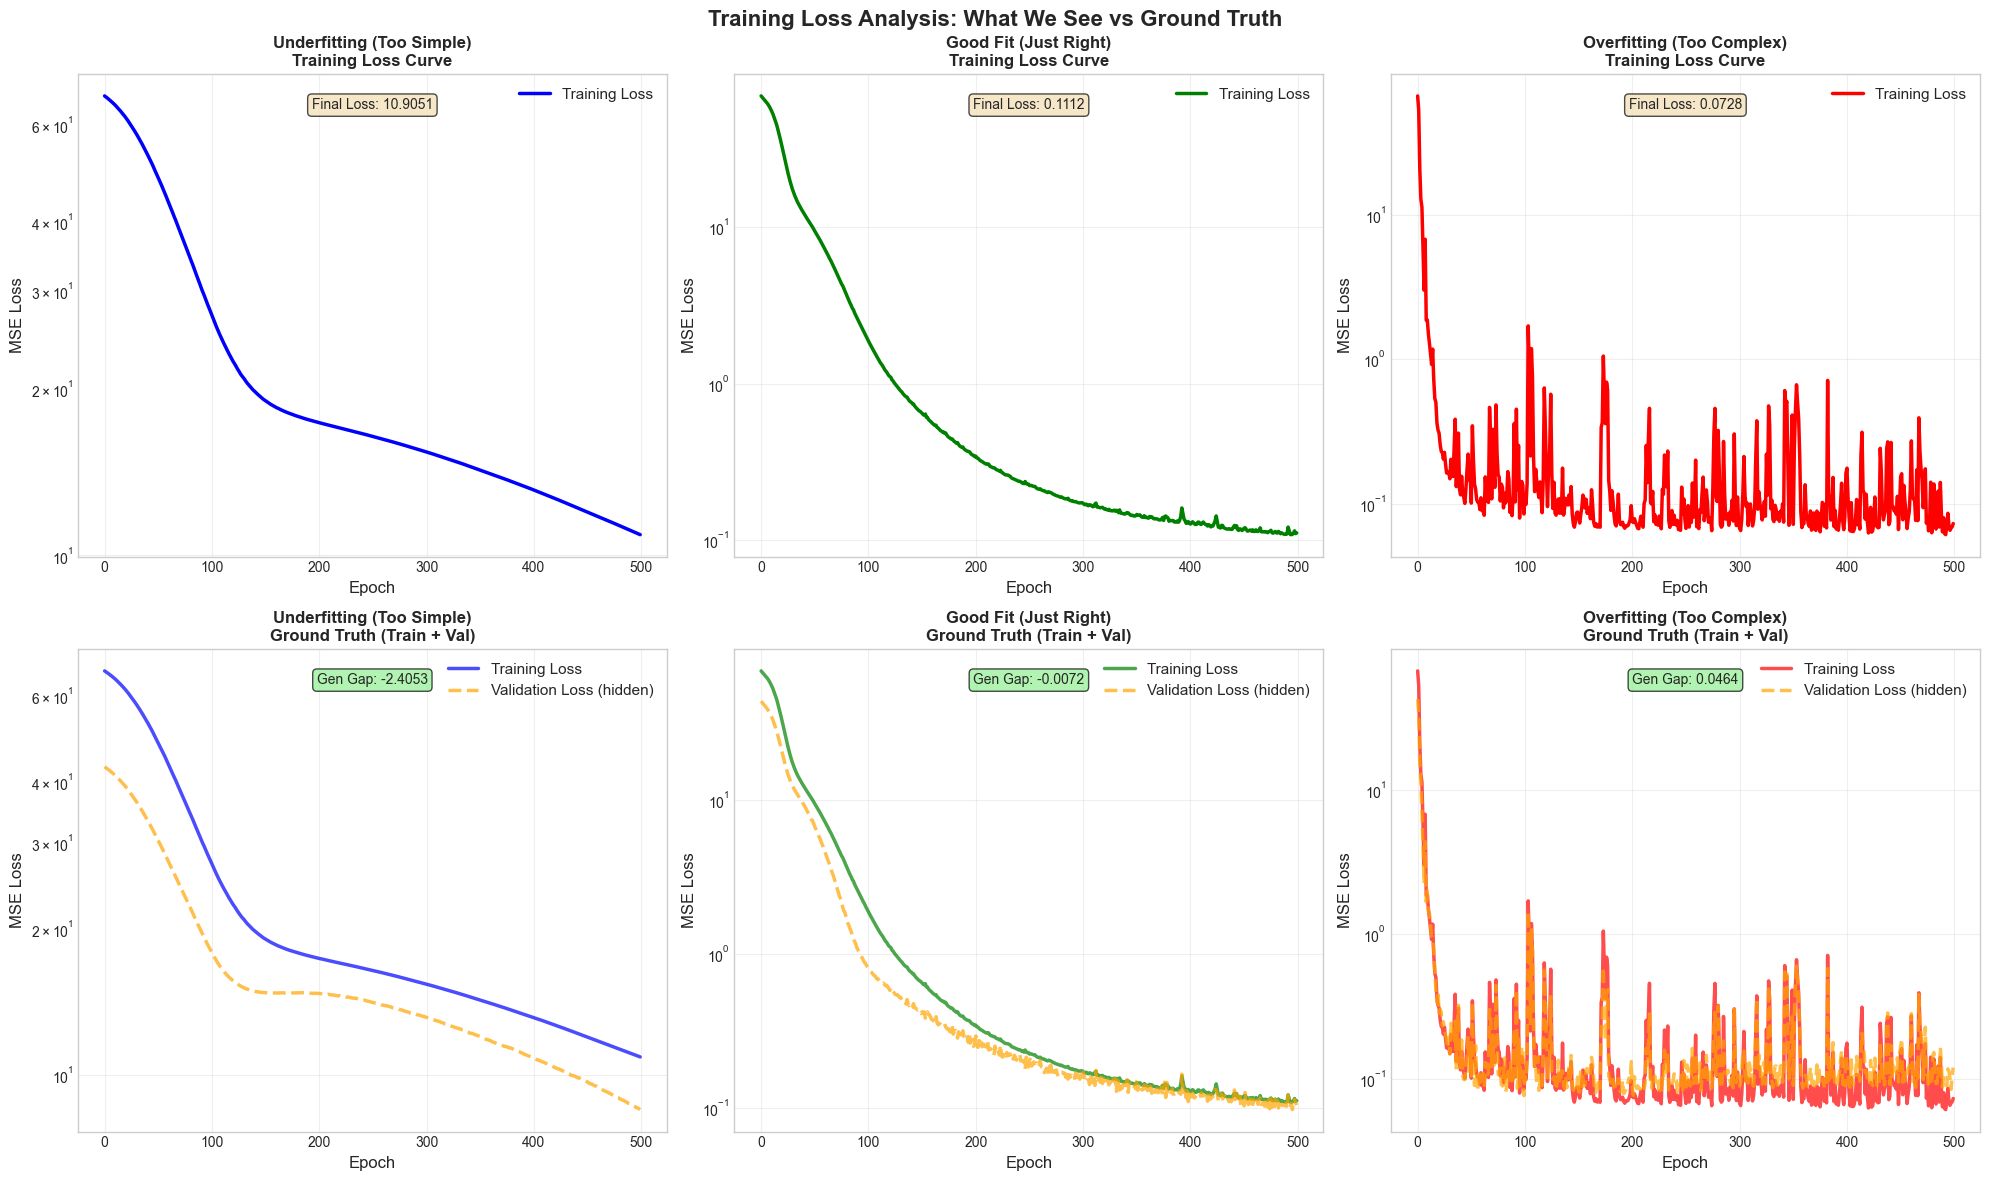


OBSERVATIONS FROM TRAINING CURVES ONLY:

Underfitting (Too Simple):
  Initial loss: 67.5617
  Final loss: 10.9051
  Total reduction: 56.6566
  Final 10 epochs avg decrease: 0.021605
  → Inference: HIGH final loss suggests UNDERFITTING

Good Fit (Just Right):
  Initial loss: 68.5158
  Final loss: 0.1112
  Total reduction: 68.4047
  Final 10 epochs avg decrease: -0.000223
  → Inference: HIGH final loss suggests UNDERFITTING

Overfitting (Too Complex):
  Initial loss: 66.7439
  Final loss: 0.0728
  Total reduction: 66.6711
  Final 10 epochs avg decrease: -0.000902
  → Inference: Moderate loss - uncertain (AMBIGUOUS)


In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

colors = {'Underfitting (Too Simple)': 'blue', 
          'Good Fit (Just Right)': 'green',
          'Overfitting (Too Complex)': 'red'}

# Row 1: Training loss curves (what we see)
for idx, (model_name, model_data) in enumerate(trained_models.items()):
    ax = axes[0, idx]
    history = model_data['history']
    
    # Plot training loss only
    epochs = range(len(history['train_loss']))
    ax.plot(epochs, history['train_loss'], linewidth=2.5, 
            color=colors[model_name], label='Training Loss')
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('MSE Loss', fontsize=12)
    ax.set_title(f'{model_name}\nTraining Loss Curve', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Add annotations about what we can infer
    final_loss = history['train_loss'][-1]
    ax.text(0.5, 0.95, f'Final Loss: {final_loss:.4f}', 
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Row 2: Training AND validation loss (ground truth - what we don't see)
for idx, (model_name, model_data) in enumerate(trained_models.items()):
    ax = axes[1, idx]
    history = model_data['history']
    
    epochs = range(len(history['train_loss']))
    ax.plot(epochs, history['train_loss'], linewidth=2.5, 
            color=colors[model_name], label='Training Loss', alpha=0.7)
    ax.plot(epochs, history['val_loss'], linewidth=2.5, linestyle='--',
            color='orange', label='Validation Loss (hidden)', alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('MSE Loss', fontsize=12)
    ax.set_title(f'{model_name}\nGround Truth (Train + Val)', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Calculate generalization gap
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    gap = final_val_loss - final_train_loss
    
    ax.text(0.5, 0.95, f'Gen Gap: {gap:.4f}', 
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', 
                     facecolor='red' if gap > 0.1 else 'lightgreen', 
                     alpha=0.7))

plt.suptitle('Training Loss Analysis: What We See vs Ground Truth', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print observations
print("\n" + "="*80)
print("OBSERVATIONS FROM TRAINING CURVES ONLY:")
print("="*80)
for model_name, model_data in trained_models.items():
    history = model_data['history']
    final_loss = history['train_loss'][-1]
    initial_loss = history['train_loss'][0]
    loss_reduction = initial_loss - final_loss
    
    print(f"\n{model_name}:")
    print(f"  Initial loss: {initial_loss:.4f}")
    print(f"  Final loss: {final_loss:.4f}")
    print(f"  Total reduction: {loss_reduction:.4f}")
    print(f"  Final 10 epochs avg decrease: {np.mean(history['loss_decrease_rate'][-10:]):.6f}")
    
    # Diagnosis based on training curve only
    if final_loss > 0.1:
        print(f"  → Inference: HIGH final loss suggests UNDERFITTING")
    elif final_loss < 0.01:
        print(f"  → Inference: VERY LOW loss - could be good fit OR overfitting (AMBIGUOUS)")
    else:
        print(f"  → Inference: Moderate loss - uncertain (AMBIGUOUS)")

## Part 4: The Ambiguity Problem

### What Training Loss CANNOT Tell Us:

Even with the training curves above, we face ambiguity:

1. **Low training loss** (0.01):
   - ✅ Could mean: Model fits the true pattern well
   - ❌ Could mean: Model memorizes noise and will generalize poorly
   
2. **Plateaued training loss** (0.15):
   - ✅ Could mean: Model converged to best possible fit
   - ❌ Could mean: Model lacks capacity to fit the pattern

3. **Still-decreasing loss**:
   - ✅ Could mean: Model is still learning useful patterns
   - ❌ Could mean: Model is starting to memorize individual points

### We Need Additional Signals!

Let's identify signals that resolve these ambiguities.

## Part 5: Additional Diagnostic Signals

When validation data is unavailable, request these signals:

### 1. **Gradient Norms**
- **Vanishing gradients** → Underfitting (optimization issue)
- **Exploding gradients** → Poor initialization or instability
- **Healthy gradients** → Normal learning

### 2. **Weight Norms**
- **Growing weights** → Potential overfitting
- **Stable weights** → Good regularization
- **Small weights** → Potential underfitting

### 3. **Learning Curves** (vary training set size)
- **Both train/val high** → Underfitting
- **Train low, val high** → Overfitting
- **Both converging** → Good fit

### 4. **Model Predictions Visualization**
- **Smooth curve** → Generalizable pattern
- **Wiggy curve** → Memorizing noise
- **Flat prediction** → Underfitting

### 5. **Training with Different Data Subsets**
- **Consistent performance** → Learning patterns
- **Inconsistent performance** → Memorizing specific examples

### 6. **Noise Sensitivity**
- **Performance robust to noise** → Good generalization
- **Performance degrades with noise** → Overfitting

### 7. **Early Stopping Analysis**
- If we had checkpoints, which epoch would we pick?

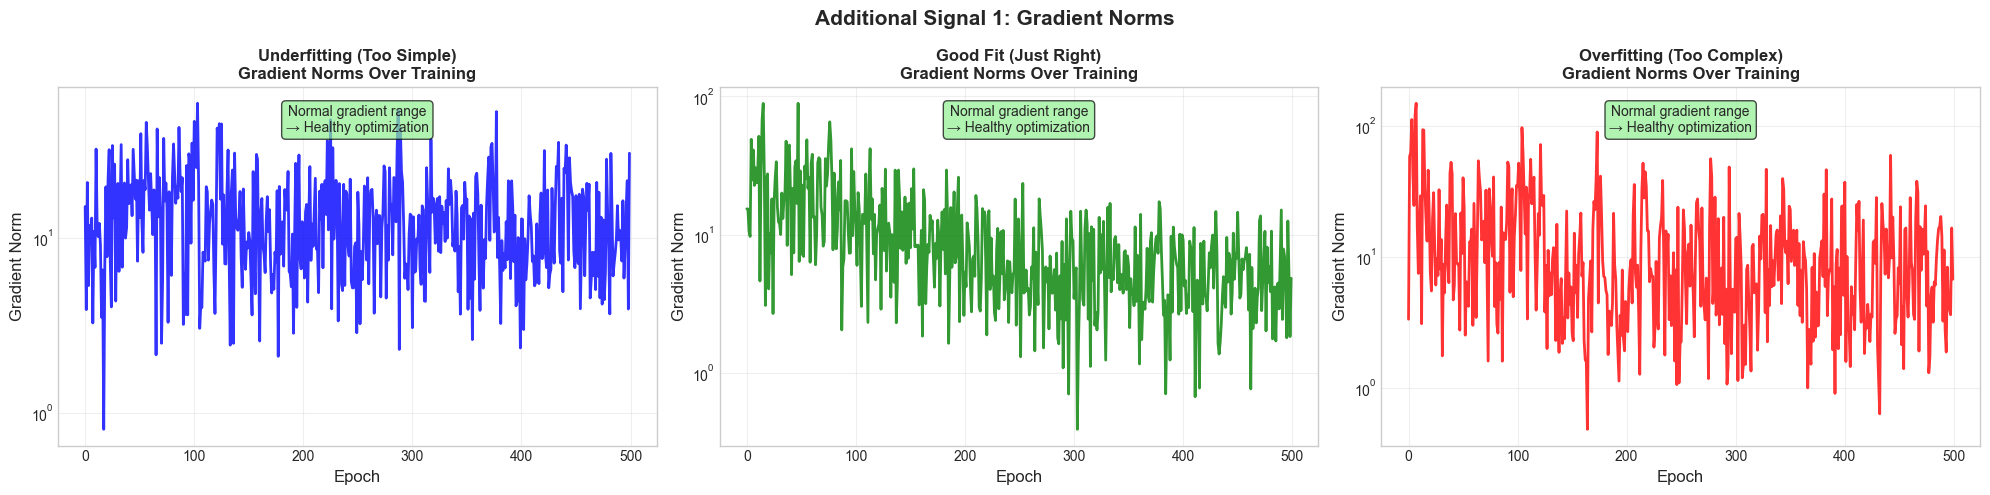


Gradient Analysis:
Underfitting (Too Simple):
  Final gradient norm: 30.311772
  Average gradient (last 50 epochs): 11.720905
Good Fit (Just Right):
  Final gradient norm: 4.848018
  Average gradient (last 50 epochs): 5.657743
Overfitting (Too Complex):
  Final gradient norm: 6.737030
  Average gradient (last 50 epochs): 10.316542


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, (model_name, model_data) in enumerate(trained_models.items()):
    ax = axes[idx]
    history = model_data['history']
    
    epochs = range(len(history['gradient_norms']))
    ax.plot(epochs, history['gradient_norms'], linewidth=2, 
            color=colors[model_name], alpha=0.8)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Gradient Norm', fontsize=12)
    ax.set_title(f'{model_name}\nGradient Norms Over Training', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Analyze gradient behavior
    final_grad = history['gradient_norms'][-1]
    avg_early_grad = np.mean(history['gradient_norms'][:50])
    
    if final_grad < 1e-4:
        diagnosis = "Vanishing gradients\n→ May indicate underfitting"
        color = 'red'
    elif final_grad > 1e2:
        diagnosis = "Large gradients\n→ Still learning or unstable"
        color = 'orange'
    else:
        diagnosis = "Normal gradient range\n→ Healthy optimization"
        color = 'lightgreen'
    
    ax.text(0.5, 0.95, diagnosis,
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))

plt.suptitle('Additional Signal 1: Gradient Norms', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nGradient Analysis:")
print("="*80)
for model_name, model_data in trained_models.items():
    history = model_data['history']
    print(f"{model_name}:")
    print(f"  Final gradient norm: {history['gradient_norms'][-1]:.6f}")
    print(f"  Average gradient (last 50 epochs): {np.mean(history['gradient_norms'][-50:]):.6f}")

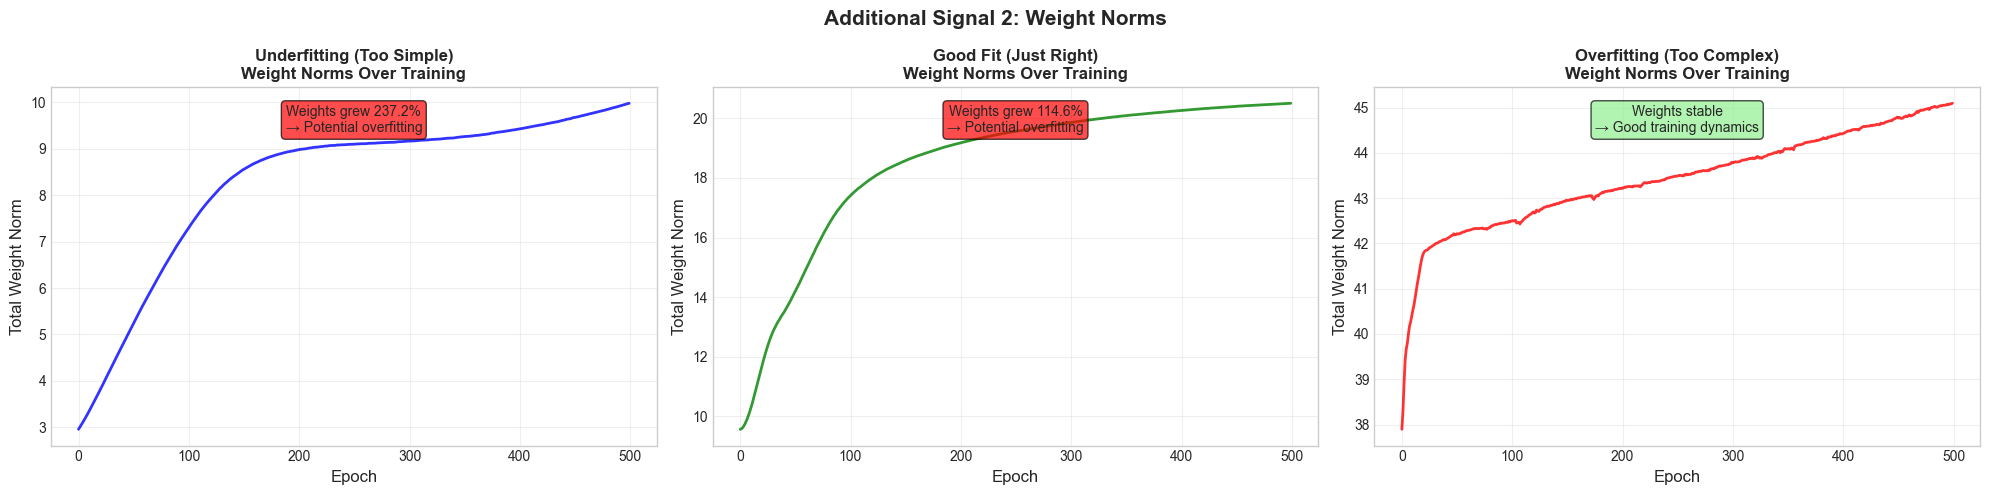


Weight Norm Analysis:
Underfitting (Too Simple):
  Initial weight norm: 2.96
  Final weight norm: 9.98
  Growth: 237.2%
Good Fit (Just Right):
  Initial weight norm: 9.56
  Final weight norm: 20.51
  Growth: 114.6%
Overfitting (Too Complex):
  Initial weight norm: 37.90
  Final weight norm: 45.09
  Growth: 19.0%


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, (model_name, model_data) in enumerate(trained_models.items()):
    ax = axes[idx]
    history = model_data['history']
    
    epochs = range(len(history['weight_norms']))
    ax.plot(epochs, history['weight_norms'], linewidth=2, 
            color=colors[model_name], alpha=0.8)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Total Weight Norm', fontsize=12)
    ax.set_title(f'{model_name}\nWeight Norms Over Training', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Analyze weight growth
    initial_weight = history['weight_norms'][0]
    final_weight = history['weight_norms'][-1]
    growth_rate = (final_weight - initial_weight) / initial_weight
    
    if growth_rate > 0.5:
        diagnosis = f"Weights grew {growth_rate*100:.1f}%\n→ Potential overfitting"
        color = 'red'
    elif growth_rate < -0.2:
        diagnosis = f"Weights decreased\n→ Strong regularization"
        color = 'yellow'
    else:
        diagnosis = f"Weights stable\n→ Good training dynamics"
        color = 'lightgreen'
    
    ax.text(0.5, 0.95, diagnosis,
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))

plt.suptitle('Additional Signal 2: Weight Norms', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nWeight Norm Analysis:")
print("="*80)
for model_name, model_data in trained_models.items():
    history = model_data['history']
    print(f"{model_name}:")
    print(f"  Initial weight norm: {history['weight_norms'][0]:.2f}")
    print(f"  Final weight norm: {history['weight_norms'][-1]:.2f}")
    print(f"  Growth: {((history['weight_norms'][-1] - history['weight_norms'][0])/history['weight_norms'][0]*100):.1f}%")

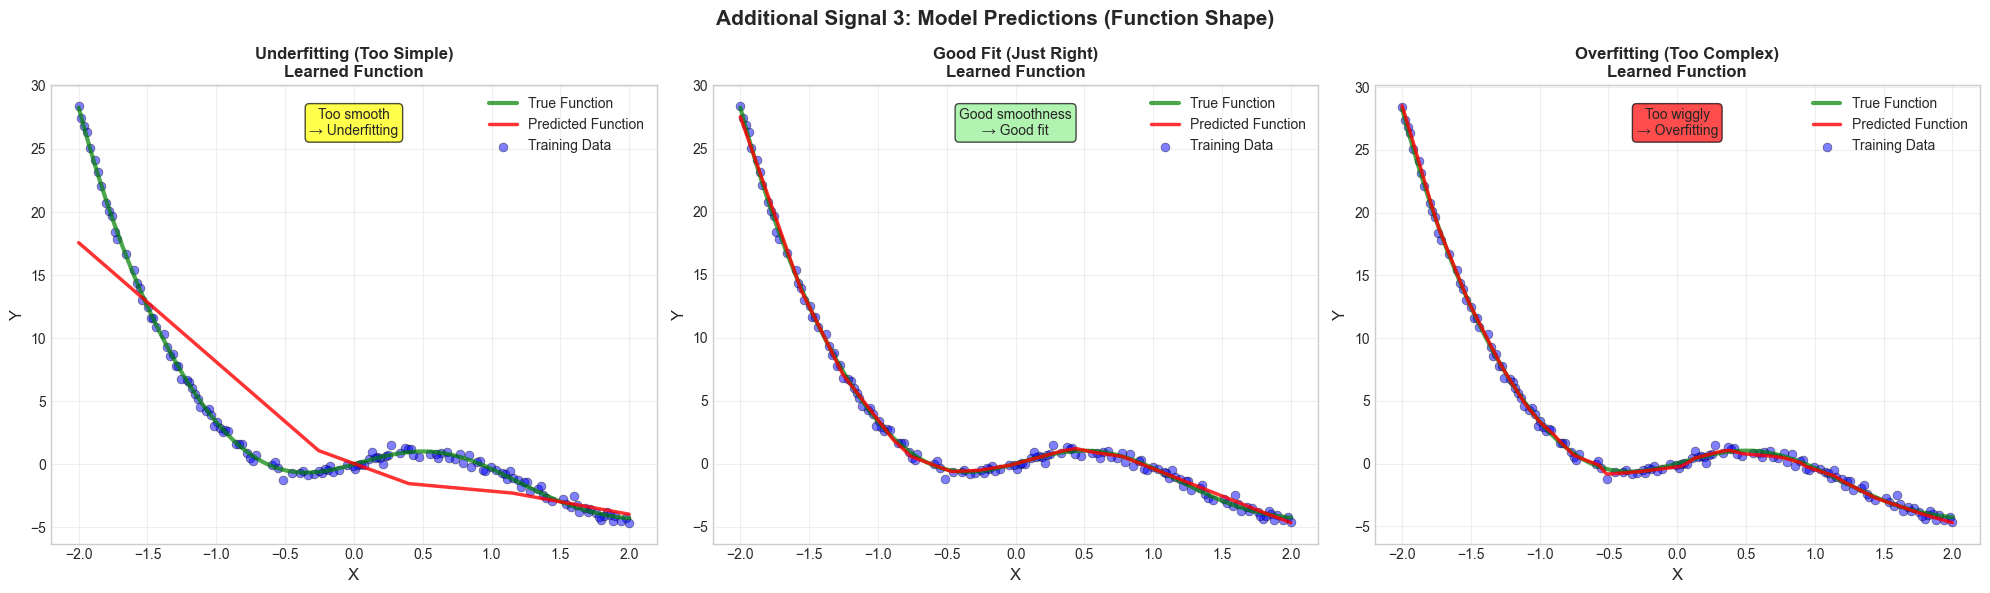


Prediction Analysis:
Underfitting (Too Simple):
  Training MSE: 10.9051
  Training MAE: 2.4735
Good Fit (Just Right):
  Training MSE: 0.1112
  Training MAE: 0.2603
Overfitting (Too Complex):
  Training MSE: 0.0728
  Training MAE: 0.2140


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (model_name, model_data) in enumerate(trained_models.items()):
    ax = axes[idx]
    
    # Get predictions
    model = model_data['model']
    model.eval()
    with torch.no_grad():
        X_grid_tensor = torch.FloatTensor(X_grid.reshape(-1, 1))
        y_pred_grid = model(X_grid_tensor).numpy().flatten()
    
    # Plot
    ax.plot(X_grid, y_grid_true, 'g-', linewidth=3, label='True Function', alpha=0.7)
    ax.plot(X_grid, y_pred_grid, 'r-', linewidth=2.5, label='Predicted Function', alpha=0.8)
    ax.scatter(X_train, y_train, c='blue', s=40, alpha=0.5, 
               edgecolors='black', linewidth=0.5, label='Training Data')
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(f'{model_name}\nLearned Function', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Analyze prediction smoothness
    # Calculate second derivative (curvature) as proxy for wiggliness
    pred_curvature = np.abs(np.gradient(np.gradient(y_pred_grid)))
    avg_curvature = np.mean(pred_curvature)
    
    true_curvature = np.abs(np.gradient(np.gradient(y_grid_true)))
    true_avg_curvature = np.mean(true_curvature)
    
    curvature_ratio = avg_curvature / true_avg_curvature
    
    if curvature_ratio < 0.5:
        diagnosis = "Too smooth\n→ Underfitting"
        color_box = 'yellow'
    elif curvature_ratio > 2.0:
        diagnosis = "Too wiggly\n→ Overfitting"
        color_box = 'red'
    else:
        diagnosis = "Good smoothness\n→ Good fit"
        color_box = 'lightgreen'
    
    ax.text(0.5, 0.95, diagnosis,
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor=color_box, alpha=0.7))

plt.suptitle('Additional Signal 3: Model Predictions (Function Shape)', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPrediction Analysis:")
print("="*80)
for model_name, model_data in trained_models.items():
    model = model_data['model']
    model.eval()
    with torch.no_grad():
        X_grid_tensor = torch.FloatTensor(X_grid.reshape(-1, 1))
        y_pred_grid = model(X_grid_tensor).numpy().flatten()
    
    # Calculate fit quality on training data
    X_train_tensor = torch.FloatTensor(X_train.reshape(-1, 1))
    y_pred_train = model(X_train_tensor).detach().numpy().flatten()
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    
    print(f"{model_name}:")
    print(f"  Training MSE: {train_mse:.4f}")
    print(f"  Training MAE: {train_mae:.4f}")